In [17]:
%matplotlib inline
import autograd.numpy as np
import autograd.scipy as sc
import pylab as plt
import seaborn as snb
import math

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from autograd.scipy.stats import multivariate_normal as mvn

# for numerical optimization
from scipy.optimize import minimize
from autograd import value_and_grad
from autograd import hessian

# for numerical integration
from numpy.polynomial.hermite import hermgauss
from scipy.integrate import quad

snb.set_style('darkgrid')
snb.set(font_scale=1.5)

def add_colorbar(im, fig, ax):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

# 02477 Bayesian Machine Learning - Exercise 3

The exercise deals with probabilistic methods for binary classification and it is divided into three parts:

- Part1: Generative classifiers
- Part2: Laplace approximations
- Part3: Bayesian Logistic regression

To make sure you get to discuss part 2 and 3 with the teaching team, we suggest moving on to part 2 and part 3 if you haven't completed part 1 before 16:00 and then finish the rest at home.

### Part 1: Generative classifiers with synthetic data

In the first part of the exercise, we will study a simple generative classifier given by

$$\begin{align*}
p(t_n = k | x_n) = \frac{p(x_n|t_n=k)p(t_n=k)}{p(x_n)},
\end{align*}$$

where
- $p(t_n = k | x_n)$ the posterior probability that the $n$'th observation belongs to class $k$ given the input point $x_n$
- $p(x_n|t_n=k)$ is the class-conditional distribution for class $k$
- $p(t_n=k)$ is the prior class probability for the $k$'th class
- $p(x_n)$ is the marginal density of the data

We will focus on binary classification, so $k$ only takes the values $0$ or $1$. 

For the class conditional distributions we will **assume** bivariate normal distributions with a **shared** covariance matrix $\Sigma$, but with class-specific mean vectors $\mu_k$. That is,
\begin{align*}
p(x_n|t_n=k) = \mathcal{N}(x_n|\mu_k, \Sigma)
\end{align*}
The **prior** probability of an observation belonging to class 1 is given by $p(t_n=1)=\pi_1$.

As we discussed in the lecture (see Bishop sec 4.2.1. for the details), these assumptions give rise to posterior class probabilities of the form

$$\begin{align*}
p(t_n = k|\mathbf{x}_n) = \sigma(w_0 + \mathbf{w}^T \mathbf{x}_n),
\end{align*}$$

where $\sigma$ is the sigmoid function and the values for $w_0$ and $\mathbf{w}$ is determined by the prior distribution and the class-conditional distributions:

\begin{align*}
\mathbf{w} &= \Sigma^{-1}(\mu_1 - \mu_0)\\
w_0 &= -\frac12 \mu_0^T \Sigma^{-1} \mu_0 + \frac12 \mu_1^T \Sigma^{-1}\mu_1 + \ln \frac{\pi_0}{\pi_1}
\end{align*}
In this exercise, we will estimate the parameters of the model using maximum likelihood (see Bishop sec. 4.2.2 for the details)
\begin{align*}
    \hat{\pi}_1 &= \frac{N_1}{N_0+N_1}\\
    \hat{\mu}_1 &= \frac{1}{N_1} \sum_{n=1}^N t_n x_n,\\
    \hat{\mu}_0 &= \frac{1}{N_0} \sum_{n=1}^N (1-t_n) x_n,\\
    \hat{\Sigma} &= \frac{N}{N_1} \mathbf{S}_1 + \frac{N}{N_0} \mathbf{S}_0
\end{align*}
where $N$ is the number of data points, $N_k$ is the number of samples in class $k$, and $\mathbf{S}_k$ is the empirical covariance of the features in clsas $k$.

As a classification rule, we will classify an input point $x$ as the class that maximizes the posterior class probability. That is,

$$
\begin{align*}
\hat{t}_n = \arg\max\limits_{k} p(t_n = k | x_n) = \arg\max\limits_{k}\sigma(w_0 + \mathbf{w}^T \mathbf{x}_n).
\end{align*}
$$



#### Part 1a: Generative classification for synthetic data
The following cell will generate a synthetic data set and fit the generative classifier on it:



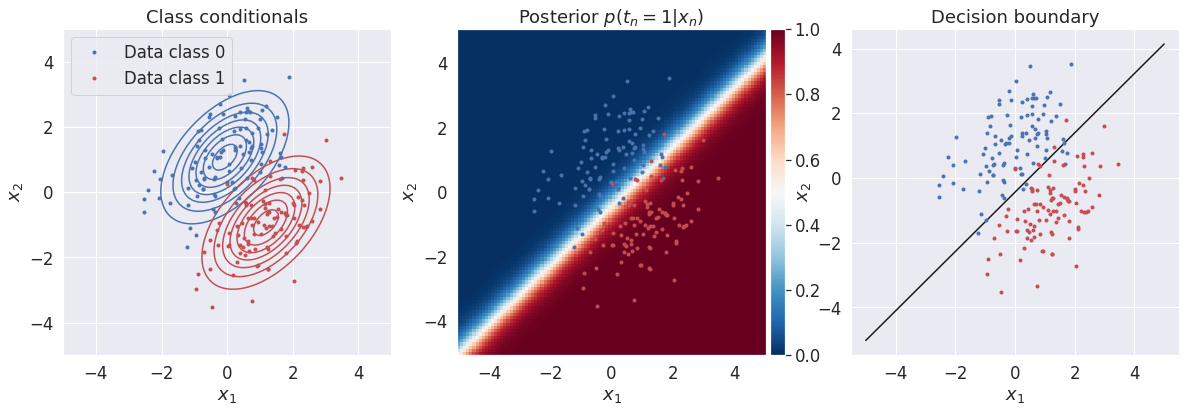

In [18]:
np.random.seed(0)

##########################################################################
# generate synthetic data
##########################################################################

# Prior probabilities
pi0 = 0.5
pi1 = 1 - pi0

# class conditional means
mu0 = np.array([0, 1])
mu1 = np.array([1, -1])

# common covariance
S = np.array([[1, 0.5], [0.5, 1]])

# generate data
N = 200
N0 = int(pi0*N)
N1 = N - N0

x0 = np.random.multivariate_normal(mu0, S, size=N0)
x1 = np.random.multivariate_normal(mu1, S, size=N1)
X = np.row_stack((x0, x1))
t = np.hstack((np.zeros(N0), np.ones(N1)))


# calculate posterior distribution
sigmoid = lambda x: 1/(1 + np.exp(-x))


##########################################################################
# classifier
##########################################################################
def fit_generative_classifier(X, t):
    # implements the method outlined in section 4.2.2 in Bishop

    # count number of examples in each class
    N0 = np.sum(t==0)
    N1 = np.sum(t==1)
    
    # estimate prior probabilities using eq. (4.73)
    pi0_hat = N0/(N0+N1)
    pi1_hat = N1/(N0+N1)
    
    # estimate means using eq. (4.75) nd (4.76)
    mu1_hat = np.mean(X[t==1, :], 0)
    mu0_hat = np.mean(X[t==0, :], 0)
    
    # estimate common covariance using eq. (4.78)-(4.80)
    S0 = np.cov(X[t==0, :].T)
    S1 = np.cov(X[t==1, :].T)
    S_hat = pi0_hat * S0 + pi1_hat*S1

    # estimate parameters using eq. (4.66)
    w = np.linalg.solve(S_hat, mu1_hat-mu0_hat)
    w0 = -0.5*mu1_hat@np.linalg.solve(S_hat, mu1_hat) + 0.5*mu0_hat@np.linalg.solve(S_hat, mu0_hat) + np.log(pi1_hat/pi0_hat)
    
    # return every
    return w0, w, pi0_hat, pi1_hat, mu0_hat, mu1_hat, S_hat


# fit model
w0, w, pi0_hat, pi1_hat, mu0_hat, mu1_hat, S_hat = fit_generative_classifier(X, t)

# function for computing posterior probabilitites of p(t_n = 1|x_n)
posterior1 = lambda x: sigmoid(w0 + x@w)

# function for computing posterior probabilitites of p(t_n = 0|x_n)
posterior0 = lambda x: 1 - posterior1(x)


##########################################################################
# preparing density plots
##########################################################################
def eval_density_grid(density_fun, P=100):
    x_grid = np.linspace(-5, 5, 100)
    X1, X2 = np.meshgrid(x_grid, x_grid)
    XX = np.column_stack((X1.ravel(), X2.ravel()))
    return x_grid, density_fun(XX).reshape((P, P))

# define and evaluate class conditional densities
log_p_class0 = lambda x: mvn.logpdf(x, mu0_hat, S_hat)
log_p_class1 = lambda x: mvn.logpdf(x, mu1_hat, S_hat)

x_grid, log_p_class0_eval = eval_density_grid(log_p_class0)
x_grid, log_p_class1_eval = eval_density_grid(log_p_class1)


##########################################################################
# plot
##########################################################################

# evaluate posterior distribution
x_grid, posterior1_eval = eval_density_grid(posterior1)

# decision boundary
decision = -(w0 + w[0]*x_grid)/w[1]


fig, ax =  plt.subplots(1, 3, figsize=(20, 6))
# first plot
ax[0].plot(x0[:, 0], x0[:, 1], 'b.', label='Data class 0')
ax[0].plot(x1[:, 0], x1[:, 1], 'r.', label='Data class 1')
ax[0].contour(x_grid, x_grid, np.exp(log_p_class0_eval), colors='b')
ax[0].contour(x_grid, x_grid, np.exp(log_p_class1_eval), colors='r')
ax[0].legend()
ax[0].set(title='Class conditionals', xlabel='$x_1$', ylabel='$x_2$')

# second plot
im = ax[1].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto')
ax[1].plot(x0[:, 0], x0[:, 1], 'b.', label='Data class 0')
ax[1].plot(x1[:, 0], x1[:, 1], 'r.', label='Data class 1')
ax[1].set(title='Posterior $p(t_n=1|x_n)$', xlabel='$x_1$', ylabel='$x_2$')
add_colorbar(im, fig, ax[1])

# third plot
ax[2].plot(x_grid, decision, 'k-')
ax[2].plot(x0[:, 0], x0[:, 1], 'b.', label='Data class 0')
ax[2].plot(x1[:, 0], x1[:, 1], 'r.', label='Data class 1')
ax[2].set(title='Decision boundary', xlabel='$x_1$', ylabel='$x_2$');

**Questions**


1.1) Explain the difference between generative and discriminative classification in your own words. 


*Hints: You will need the following distributions to describe difference: $p(t, x)$ and $p(t|x)$*

1.2) The parameters of this model is $\Sigma, \mu_1, \mu_2, \pi_0$, and $\pi_1$, how do they relate to the plots above (e.g how would changing each of the parameters affect the plots)?


1.3) Compute the analytical expression for the marginal distribution of the data, i.e. $p(x)$, using the sum rule. (this model is one of the rare cases, where we can compute the marginal likelihood $p(x)$ analytically)

*Hints*:
-  *The sum-rule states that the marginal distribution is $p(x) = \sum_{k\in\left\lbrace 0,1\right\rbrace } p(x|t=k)p(t=k)$*
-  *This question should be fairly easy given the information in the theory section above*



**Solution to 1.3**

We have that
\begin{align*}
    p(x) &= \sum_{k\in\left\lbrace 0,1\right\rbrace } p(x|t=k)p(t=k)\\
    &= \sum_{k\in\left\lbrace 0,1\right\rbrace }\mathcal{N}(x|\mu_k, \Sigma) \pi_k\\
    &= \pi_0 \mathcal{N}(x|\mu_0, \Sigma) + \pi_1 \mathcal{N}(x|\mu_1, \Sigma)
\end{align*}
Thus, the marginal distribution is a **mixture of Gaussians**.

#### Part 1b: Generative classifiers with MNIST data

next, we will use a subset of the MNIST data to further explore this approach to probabilistic classification. The MNIST data (more information here: http://yann.lecun.com/exdb/mnist/) contains a set of digital images of digits from 0-9. Each image is 28x28 pixels and is represented in a vectorized manner such that each image is represented as a vector in $\mathbb{R}^{784}$. 

In order to visualize the results, we use principal component analysis (PCA) to reduce the dimensionality to $D = 2$. We won't cover PCA in this course, but you can read more about it in chapter 12.1 in the textbook if you are unfamiliar with it.

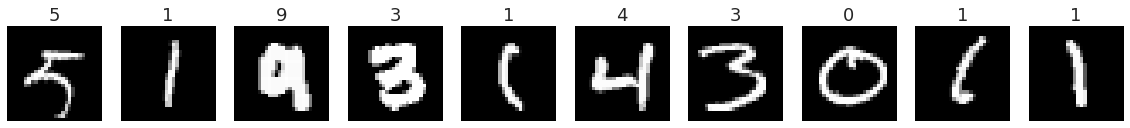

In [19]:
data = np.load('./mnist_subset.npz')
images = data['images']
labels = data['labels']

fig, ax = plt.subplots(1, 10, figsize=(20, 6))
for idx_plot, i in enumerate(np.random.choice(range(len(images)), size=10)):
    ax[idx_plot].imshow(images[i].reshape((28, 28)), cmap=plt.cm.gray)
    ax[idx_plot].set_title('%d' % labels[i])
    ax[idx_plot].axis('off')


#### Reduce dimensionality using principal component analysis

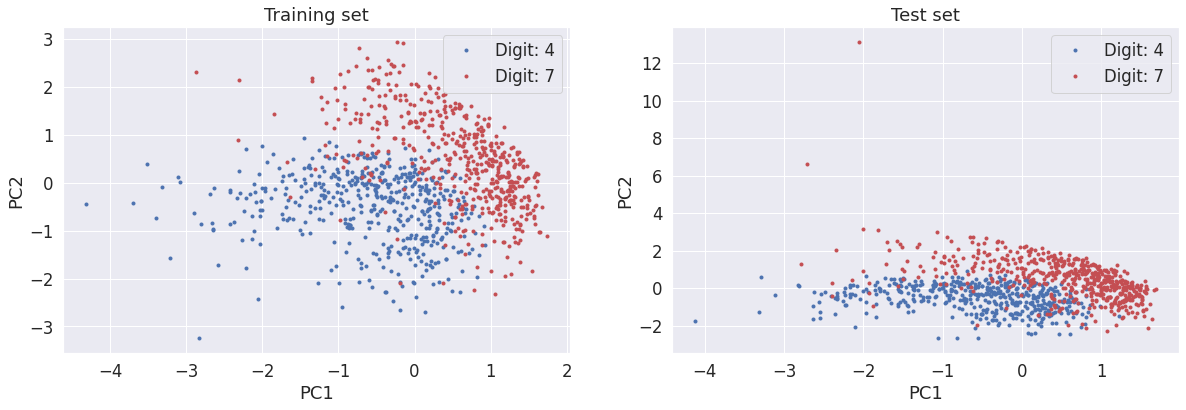

In [20]:
np.random.seed(0)

# we will only focus on binary classification using two digits
digits = [4, 7]
idx = np.logical_or(labels == digits[0], labels == digits[1])

# extract digits of interest
X = images[idx, :]
t = labels[idx].astype('float')

# set labels to 0/1
t[t == digits[0]] = 0
t[t == digits[1]] = 1

# split into training/test
N = len(X)
Ntrain = int(0.5*N)
Ntest = N - Ntrain
train_idx = np.random.choice(range(N), size=Ntrain, replace=False)
test_idx = np.setdiff1d(range(N), train_idx)

Xtrain, Xtest = X[train_idx, :], X[test_idx, :]
ttrain, ttest = t[train_idx], t[test_idx]

# standardize training set and test set
Xm, Xs = Xtrain.mean(0), Xtrain.std(0)
Xs[Xs == 0] = 1 # avoid division by zero for "always black" pixels

Xtrain_std = (Xtrain - Xm)/Xs
Xtest_std = (Xtest - Xm)/Xs

# compute projection matrix for PCA
def prep_PCA(X, dim=2):
    # reduce dimensionality to 2D using principal component analysis (PCA)
    U, s, V = np.linalg.svd(X)

    # get eigenvectors corresponding to the two largest eigenvalues
    eigen_vecs = V[:dim, :]
    eigen_vals = s[:dim]

    # set-up projection matrix
    Pmat = eigen_vecs.T*(np.sqrt(len(X))/eigen_vals)
    
    return Pmat

# project to 2D using PCA
Pmat = prep_PCA(Xtrain_std)
Z_train =Xtrain_std@Pmat
Z_test = Xtest_std@Pmat


# plot
def plot_data(Z, t, ax, digits, title=""):
    ax.plot(Z[t==0, 0], Z[t==0, 1], 'b.', label='Digit: %d' % digits[0])
    ax.plot(Z[t==1, 0], Z[t==1, 1], 'r.', label='Digit: %d' % digits[1])
    ax.legend()
    ax.set(title=title, xlabel='PC1', ylabel='PC2');

fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(Z_train, ttrain, ax[0], digits, title='Training set')
plot_data(Z_test, ttest, ax[1], digits, title='Test set')

**Questions**


Implement the following using the code from above 1:

1.4) Fit the generative classifier from part 1 to this training set (the subset of 4 vs 7 in the 2D PCA space)

1.5) Make plots of the class-conditional distributions, the posterior class probabilities and the decision boundary like in part 1

1.6) Comment on whether the assumptions are reasonable for this data (using the plots from above)

1.7) Classify all data points according to the most probable class and report the training error and test error




#### Solution

Training error:	0.13 (0.01)
Test error:	0.12 (0.01)


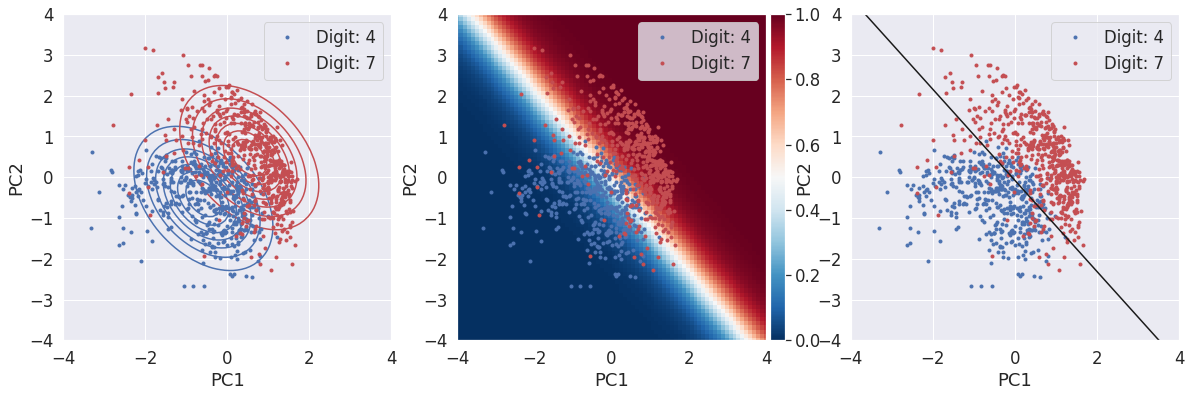

In [21]:
# compute classification error and std. error
def compute_err(t, tpred):
    # t and tpred are flat arrays of the true target and predicted targets, respectively.
    return np.mean(tpred != t), np.std(tpred != t)/np.sqrt(len(t))

# fit model
w0, w, pi0_hat, pi1_hat, mu0_hat, mu1_hat, S_hat = fit_generative_classifier(Z_train, ttrain)

posterior1 = lambda x: sigmoid(w0 + x@w)

# evaluate class conditionals
log_p_class0 = lambda x: mvn.logpdf(x, mu0_hat, S_hat)
log_p_class1 = lambda x: mvn.logpdf(x, mu1_hat, S_hat)

x_grid, log_p_class0_eval = eval_density_grid(log_p_class0)
x_grid, log_p_class1_eval = eval_density_grid(log_p_class1)


# evaluate posterior distribution
x_grid, posterior1_eval = eval_density_grid(posterior1)

# decision boundary
decision = -(w0 + w[0]*x_grid)/w[1]

ttrain_hat = 1.0*(posterior1(Z_train) > 0.5)
ttest_hat = 1.0*(posterior1(Z_test) > 0.5)


print('Training error:\t%3.2f (%3.2f)' % compute_err(ttrain, ttrain_hat))
print('Test error:\t%3.2f (%3.2f)' % compute_err(ttest, ttest_hat))


fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# first plot
plot_data(Z_test, ttest, ax[0], digits)
ax[0].contour(x_grid, x_grid, np.exp(log_p_class0_eval), colors='b')
ax[0].contour(x_grid, x_grid, np.exp(log_p_class1_eval), colors='r')
ax[0].set(xlim = (-4, 4), ylim=(-4, 4))
ax[0].legend()

# second plot
plot_data(Z_test, ttest, ax[1], digits)
im=ax[1].pcolormesh(x_grid, x_grid, posterior1_eval, cmap=plt.cm.RdBu_r, shading='auto')
ax[1].set(xlim = (-4, 4), ylim=(-4, 4))
ax[1].legend()
add_colorbar(im, fig, ax[1])

# third plot
plot_data(Z_test, ttest, ax[2], digits)
ax[2].plot(x_grid, decision, 'k-')
ax[2].set(xlim = (-4, 4), ylim=(-4, 4))
ax[2].legend();


### Part 2: The Laplace approximation in 1D

Before turning to Bayesian logistic regression, we will look at the Laplace approximation and study some of its properties.
The posterior distribution for most models of practical interest is not analytically tractable. Therefore, we will often resort to approximate posterior inference. 
We will study several different methods for approximating the posterior distribution in the course. The simplest method is called the **Laplace approximation**.

The purpose of this exercise is to become familiar with the Laplace approximation and investigate how well the approximation can approximate various distributions of interest. Below we compute the Laplace approximation for three different target distributions and compare various properties of the approximation and the target distribution.

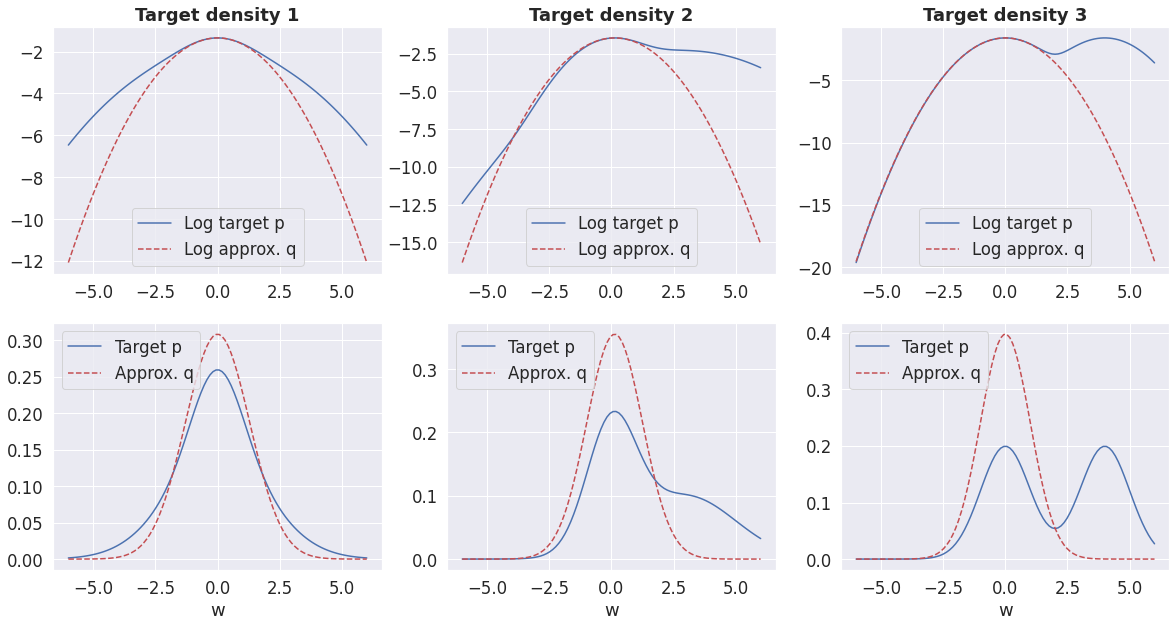

In [22]:
# Gaussian density
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) -0.5*np.log(2*np.pi*v)
npdf = lambda x, m, v: np.exp(log_npdf(x, m, v))

target_densities = [lambda w: 0.3*npdf(w, 0, 1) + 0.7*npdf(w, 0, 4),
                    lambda w: 0.5*npdf(w, 0, 1) + 0.5*npdf(w, 3, 4),
                    lambda w: 0.5*npdf(w, 0, 1) + 0.5*npdf(w, 4, 1)]


def laplace_approximation(target, w0):
    """ Computes the Laplace approximation of target density """
    
    obj = lambda w: -np.log(target(w))
    
    result = minimize(value_and_grad(obj), w0, jac=True)
            
    if result.success:
        m = result.x
        sigma2_inv = hessian(obj)(m)
        sigma2 = 1/sigma2_inv
        return m[0], sigma2[0,0]
    else:
        print('Optimization failed!')
        return None, None
    
    
# initial point for optimization
w0 = 0

ws = np.linspace(-6, 6, 100)

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, target_density in enumerate(target_densities):

    # compute approximation
    m, sigma2 = laplace_approximation(target_density, w0)
    
    # approximate density
    q = lambda w: npdf(w, m, sigma2)
    
    # for plotting
    log_q = np.log(q(ws))
    log_q_unnormalized = log_q + np.log(target_density(m)) - np.log(q(m))
    
    ax = axes[0, i]
    ax.plot(ws, np.log(target_density(ws)), 'b', label='Log target p')
    ax.plot(ws, log_q_unnormalized, 'r--', label='Log approx. q')
    ax.legend()
    ax.set_title('Target density %d' % (i+1), fontweight='bold')
    
    ax = axes[1, i]
    ax.plot(ws, target_density(ws), 'b', label='Target p')
    ax.plot(ws, q(ws), 'r--', label='Approx. q')
    ax.set_xlabel('w')
    ax.legend(loc='upper left')


Use the code and figures above to answer the following questions:

**Questions**


2.1) Explain the Laplace approximation in your own words and relate it to the code above. How is the Laplace approximation computed (e.g. how do we obtain the parameters of the approximation?)


2.2) Describe the properties of the approximations qualitatively, e.g. what aspects of the target density is captured well and which are not.


*Hints: How well does the Laplace approximation capture different distributional quantities? mode? mean? variance? tails? multimodality? etc?*


2.3) Does the result of the Laplace approximation depend on the initial value used for the optimization?





### Part3: Bayesian logistic regression

In the last part of the exercise, we will use the Laplace approximation to approximate the posterior distribution of a Bayesian logistic regression model. We will work with the following model

$$\begin{align*}
t_n|\mathbf{w} &\sim \text{Ber}(\sigma(\mathbf{w}^T \phi(\mathbf{x_n})))\\
\mathbf{w} &\sim \mathcal{N}(0, \mathbf{I}),
\end{align*}$$

where $\sigma$ is the logistic sigmoid function and $\mathbf{w}$ is the parameters of the model.  Note here we assume that $w_0$ is the intercept and that the first entry in $\phi(\mathbf{x_n})$ is always $1$. The Laplace approximation of the posterior is given by
\begin{align*}
q(\mathbf{w}) = \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}),
\end{align*}
where $\mathbf{m} = \mathbf{w}_{\text{MAP}}$ and $\mathbf{S}$ are the estimates for the posterior mean and covariance matrix, respectively. Note that even if $q(\mathbf{w}) \approx p(\mathbf{w}|\mathbf{t})$ is an approximate posterior distribution, it is common to write $q(\mathbf{w})$ instead of $q(\mathbf{w}|\mathbf{t})$.


The posterior predictive distribution is given by
\begin{align*}
p(t_*=1|\mathbf{t}, \mathbf{x}_*) = \int p(t_*|\mathbf{x}_*, \mathbf{w}) p(\mathbf{w}|\mathbf{t}) \text{d}\mathbf{w} \approx \int p(t_*|\mathbf{x}_*, \mathbf{w}) q(\mathbf{w}) \text{d}\mathbf{w} = \int \sigma(\mathbf{w}^T \phi(\mathbf{x_n})) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d}\mathbf{w}
\end{align*}

The integral above is a high-dimensional integral over the parameter space. However, because of the structure of the model, this can be reduced to a 1D integral, which is much easier to compute numerically
\begin{align*}
p(t_*=1|\mathbf{t}, \mathbf{x}_*) \approx \int \sigma(\mathbf{w}^T \phi(\mathbf{x_n})) \mathcal{N}(\mathbf{w}|\mathbf{m}, \mathbf{S}) \text{d}\mathbf{w} = \int \sigma(y) \mathcal{N}(y|m_*, \sigma_*^2) \text{d}y,
\end{align*}
where $m_* = \mathbf{m}^T \phi(\mathbf{x}_*)$ and $\sigma^2_* = \phi(\mathbf{x}_*)^T\mathbf{S}\phi(\mathbf{x}_*))$. In this exercise, we will approximate this integrals using a numerical integration method called Gauss-Hermite integration, which is often very fast and accurate for low-dimensional integrals wrt. to Gaussian distributions. However, this details of how Gauss-Hermite integration works the method is beyond the scope of the course, so we will simply use it as a tool.




We will fit this model to the MNIST dataset from above. The following cell provides a simple implementation of Bayesian logistic regression.

In [23]:
class BayesianLogisticRegression(object):
    """ Bayesian Logistic Regression with i.i.d. Gaussian priors """
    
    def __init__(self, X, t, alpha=1):
        
        # data and hyperparameters
        self.X, self.t  = X, t
        self.N, self.num_params = self.X.shape
        self.alpha = alpha

        # fit
        self.m, self.S, self.A = None, None, None
        self.compute_laplace_approximation()

    def log_prior(self, w):
        return np.sum(log_npdf(w.T, 0, 1/self.alpha))

    def log_likelihood(self, w):

        # compute linear part
        f = self.X@w
        
        # straight-forward implementation, but can be numerically unstable
        #log_bernoulli = lambda x, p: x*np.log(p) + (1-x)*np.log(1-p)
        #return np.sum(log_bernoulli(self.y, sigmoid(f)))

        # mathematicallly equivalent, but numerically more stable implementation
        log_bernoulli_logit = lambda x, z:  + x*z - np.log( 1+ np.exp(z))
        return np.sum(log_bernoulli_logit(self.t, f))
        
    def log_joint(self, w):
        return self.log_prior(w) + self.log_likelihood(w)
    
    def compute_laplace_approximation(self, w_init=None):

        if w_init is None:
            w_init = np.zeros(self.num_params)

        cost_fun = lambda w: -self.log_joint(w)
        result = minimize(value_and_grad(cost_fun), w_init, jac=True)

        if result.success:
            w_MAP = result.x
            self.m = w_MAP[:, None]    
            self.A = hessian(cost_fun)(w_MAP)
            self.S = np.linalg.inv(self.A)
            return self.m, self.S
        else:
            print('Warning optimization failed')
            return None, None
    
    def compute_marginal_likelihood(self):
        return self.log_joint(self.m.ravel()) + 0.5*self.num_params*np.log(2*np.pi) - 0.5*np.linalg.slogdet(self.A)[1]
                
    def compute_posterior_y(self, Phi):
        """ computes the posterior distribution of y(x, w) = w^T phi(x) """
        mu_y = np.dot(Phi, self.m)
        
        # same as var_f = np.diag(np.dot(np.dot(Phi, self.S), Phi.T))[:, None], but more efficient
        var_y = np.sum((Phi@self.S) * Phi, axis=1)[:, None]
        return mu_y, var_y

    def compute_predictive_prob(self, Phi, M=20):
        """ computes the posterior expectation of sigmoid(y(x, w)) using Gauss-Hermite integration """
        mu_f, var_f = self.compute_posterior_y(Phi)

        # numerical integration using Gauss-Hermite integration
        xg, wg = hermgauss(M)
        xg2 = np.sqrt(2)*np.sqrt(var_f)*xg + mu_f
        return np.sum(wg*sigmoid(xg2), 1)/np.sqrt(np.pi)        


Let's apply this model to our MNIST dataset:

Estimates of weights:
-0.084 (0.11)
+2.8 (0.18)
+2.4 (0.17)

Marginal likelihood: -294.11


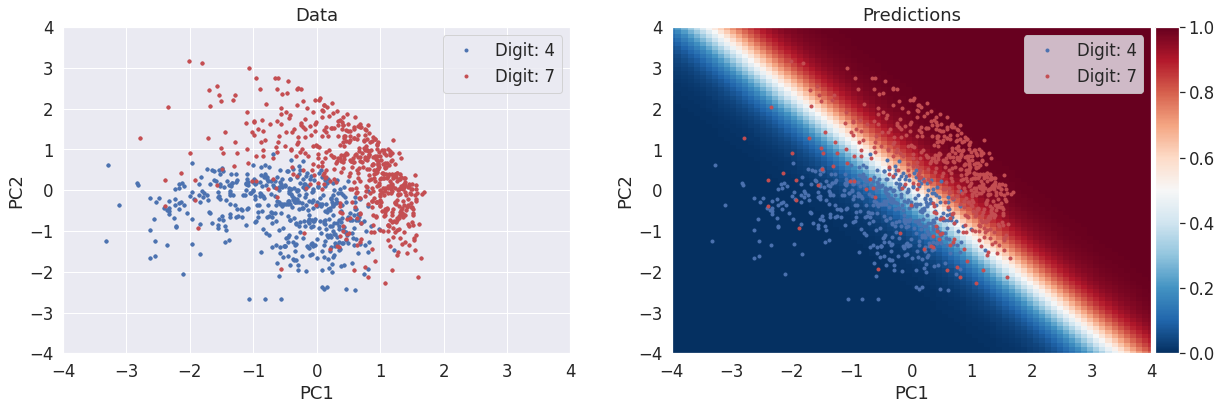

In [24]:
np.random.seed(0)

# design matrix
design_matrix = lambda x: np.column_stack((np.ones(len(x)), x))
#design_matrix = lambda x: np.column_stack((np.ones(len(x)), x, x**2))
#design_matrix = lambda x: np.column_stack((np.ones(len(x)), x, x**2, x**3))

# fit model
model = BayesianLogisticRegression(design_matrix(Z_train), ttrain)

# report estimated means and standard deviation
std = np.sqrt(np.diag(model.S))
print('Estimates of weights:')
for i in range(model.num_params):
    print(f'{model.m[i,0]:+4.2} ({std[i]:4.2})')
print('')
print(f'Marginal likelihood: {model.compute_marginal_likelihood():3.2f}')

# preditive class probabilities for grid
posterior1_blr = lambda x: model.compute_predictive_prob(design_matrix(x))
x_grid, post1_blr_eval = eval_density_grid(posterior1_blr)

# plot
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
plot_data(Z_test, ttest, ax[0], digits)
ax[0].plot(Z_test[ttest==0, 0], Z_test[ttest==0, 1], 'b.', label='Test set for digit %d' % digits[0])
ax[0].plot(Z_test[ttest==1, 0], Z_test[ttest==1, 1], 'r.', label='Test set for digit %d' % digits[1])
ax[0].set(xlim=(-4, 4), ylim=(-4, 4), title='Data')

im = ax[1].pcolormesh(x_grid, x_grid, post1_blr_eval, cmap=plt.cm.RdBu_r, shading='auto')
plot_data(Z_test, ttest, ax[1], digits)
ax[1].set(xlim=(-4, 4), ylim=(-4, 4), title='Predictions')
add_colorbar(im, fig, ax[1])


In [25]:
# compute predictive class probabilities for training and test
ptrain_hat = model.compute_predictive_prob(design_matrix(Z_train))
ptest_hat = model.compute_predictive_prob(design_matrix(Z_test))

# classify
ttrain_hat = 1.0*(ptrain_hat >0.5)
ttest_hat = 1.0*(ptest_hat >0.5)

# evaluate performance
print('Training error:\t%3.2f (%3.2f)' % compute_err(ttrain, ttrain_hat))
print('Test error:\t%3.2f (%3.2f)' % compute_err(ttest, ttest_hat))


Training error:	0.12 (0.01)
Test error:	0.12 (0.01)


**Questions**:

3.1) Why do we need the sigmoid-function in the model?

3.2) Describe and compare the model assumptions for the two models (the Bayesian logistic regression and the generative classifier in part1)?

*Hints: Look at the distributions imposed in part 1 and part 3*

3.3) The Hessian of the log joint distribution determines the posterior covariance matrix in the Laplace approximation and therefore also the posterior uncertainty. What are the two components contributing to the Hessian?
*Hints: See Bishop eq. (4.143)*



#### Visualizing the uncertainty of model

In the  Bayesian logistic regression model, we assign a prior distribution to the weights $\mathbf{w}$ of the model. Using Bayes' theorem and the Laplace approximation, we obtain a posterior distribution for $\mathbf{w}$. Let's inspect the a prior and posterior distribution for for $\mathbf{w}$ (left plot below).

Using our classification rule, the decision boundary corresponds to points where the predictive class probabilities are equal to 0.5 or equivalently when $y(\mathbf{x}) = 0$. 

We can use this fact to visualize the  posterior uncertainty of the decision boundary by propagating the posterior uncertainty for $\mathbf{w}$ to the decision boundary. We can do this by generating $S$ posterior samples of $\mathbf{w}^{(i)} \sim q(\mathbf{w}|\mathbf{t})$ for from the (approximate) posterior distribution and plot the decision boundary corresponding to each sample.

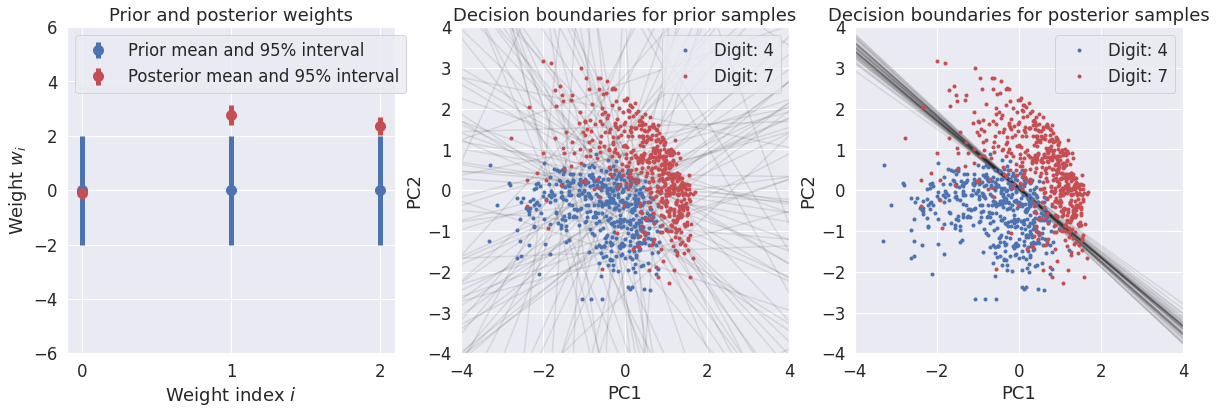

In [26]:
np.random.seed(0)

num_params = model.num_params
m0 = np.zeros(num_params)
S0 = 1/model.alpha * np.identity(num_params)

# let's generate a bunch of samples from the prior and posterior
w_prior_samples = np.random.multivariate_normal(m0, S0, size=100)
w_posterior_samples = np.random.multivariate_normal(model.m.ravel(), model.S, size=50)

def plot_decision_boundary_for_all_samples(ax, w_samples):

    # for each sample, plot when y(x) crosses zero
    for w_sample in w_samples:
        y_fun = lambda x: np.dot(design_matrix(x), w_sample[:, None])
        x_grid, y_sample = eval_density_grid(y_fun)
        ax.contour(x_grid, x_grid, y_sample.T, [0], colors='k', alpha=0.1)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].errorbar(range(num_params), m0, 2*np.sqrt(np.diag(S0)), color='b', label='Prior mean and 95% interval', linewidth=5, linestyle='', markersize=10, marker='o')
ax[0].errorbar(range(num_params), model.m.ravel(), 2*np.sqrt(np.diag(model.S)), color='r', label='Posterior mean and 95% interval', linewidth=5, linestyle='', markersize=10, marker='o')
ax[0].legend(loc='upper left')
ax[0].set(xlabel='Weight index $i$', ylabel='Weight $w_i$', ylim=(-6, 6), title='Prior and posterior weights', xticks=range(num_params))

plot_data(Z_test, ttest, ax[1], digits)
plot_decision_boundary_for_all_samples(ax[1], w_prior_samples)
ax[1].set(xlim=(-4, 4), ylim=(-4, 4), title='Decision boundaries for prior samples')
ax[1].legend()

plot_data(Z_test, ttest, ax[2], digits)
plot_decision_boundary_for_all_samples(ax[2], w_posterior_samples)
ax[2].set(xlim=(-4, 4), ylim=(-4, 4), title='Decision boundaries for posterior samples')
ax[2].legend()


**Questions**

3.4) Generate $S = 100$ samples from **the prior distribution** and visualize the corresponding decision boundaries in the center panel above in the same way as it is done for the posterior. Comment on the result.

3.5)  Based on the posterior distribution of the weights, do you expect all weights to be equally important for the classification performance?

3.6) Add more features to the design matrix, e.g. x**2. What is the best test error you can achieve?

